In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix,bmat
import gc

from sklearn.preprocessing import LabelBinarizer

import xgboost as xgb

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
cats = ['Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker','Other']

In [55]:
data = pd.concat([pd.read_csv('./../new_data/%d.csv' % year)[['Cat','Shots_taken_from_location','Started_at_Z',
        'Distance_from_hole','Hole','Round','Course_#','Year','Green_to_work_with']] for year in range(2003,2017)])

In [56]:
data = data[data.Cat=='Green']

In [57]:
test_inds = np.random.choice(range(len(data)),len(data)/5,replace=False)
test_set = set(test_inds.tolist())
train_inds = np.array([ind for ind in range(len(data)) if ind not in test_set])
train = data.iloc[train_inds,:]
test = data.iloc[test_inds,:]
data = None
gc.collect();

In [58]:
len(train),len(test)

(4671287, 1167821)

In [59]:
train.insert(len(train.columns),'Year-Course',train.Year.astype(str).str.cat(train['Course_#'].astype(str),sep='-'))
test.insert(len(test.columns),'Year-Course',test.Year.astype(str).str.cat(test['Course_#'].astype(str),sep='-'))
train.insert(len(train.columns),'Hole-Course',train.Hole.astype(str).str.cat(train['Course_#'].astype(str),sep='-'))
test.insert(len(test.columns),'Hole-Course',test.Hole.astype(str).str.cat(test['Course_#'].astype(str),sep='-'))

train.insert(len(train.columns),'Hole-Year-Course',train.Hole.astype(str).str.cat(
                                    [train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Hole-Year-Course',test.Hole.astype(str).str.cat(
                                    [test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))
train.insert(len(train.columns),'Round-Year-Course',train.Round.astype(str).str.cat(
                                    [train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Round-Year-Course',test.Round.astype(str).str.cat(
                                    [test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))

train.insert(len(train.columns),'Hole-Round-Year-Course',train.Hole.astype(str).str.cat(
                        [train.Round.astype(str),train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Hole-Round-Year-Course',test.Hole.astype(str).str.cat(
                        [test.Round.astype(str),test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))

In [60]:
test.head(3)

,Cat,Shots_taken_from_location,Started_at_Z,Distance_from_hole,Hole,Round,Course_#,Year,Green_to_work_with,Year-Course,Hole-Course,Hole-Year-Course,Round-Year-Course,Hole-Round-Year-Course
637198,Green,2,-0.513,36.673141,6,1,752,2013,33.271815,2013-752,6-752,6-2013-752,1-2013-752,6-1-2013-752
981808,Green,1,-0.014,1.051178,12,4,11,2010,34.446841,2010-11,12-11,12-2010-11,4-2010-11,12-4-2010-11
955548,Green,1,-0.029,1.262386,1,1,4,2006,35.029240,2006-4,1-4,1-2006-4,1-2006-4,1-1-2006-4


In [61]:
lbins = {}

In [41]:
X_train = csr_matrix(train.values[:,np.array([2,3])].astype(float))
for col in [6,9,10,11,12,13]:
    lbins[col] = LabelBinarizer(sparse_output=True)
    lbins[col].fit(train.values[:,col].astype(str))
    X_train = bmat([[X_train,lbins[col].transform(train.values[:,col].astype(str))]],format='csr')

In [42]:
y_train = train.Shots_taken_from_location.values

In [43]:
train = None
gc.collect();

In [45]:
X_test = csr_matrix(test.values[:,np.array([2,3])].astype(float))
for col in [6,9,10,11,12,13]:
    X_test = bmat([[X_test,lbins[col].transform(test.values[:,col].astype(str))]],format='csr')

In [46]:
y_test = test.Shots_taken_from_location.values

In [47]:
test = None
gc.collect();

In [48]:
assert X_train.shape[1]==X_test.shape[1]

In [49]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [50]:
X_train,X_test,y_train,y_test = None,None,None,None
gc.collect();

In [51]:
params = {'objective':'reg:linear','silent':0,'eta':.03,'max_depth':6,'subsample':.5,'min_child_weight':5,
          'alpha':.3,'lambda':1.5}
watchlist  = [(dtrain,'train'),(dtest,'eval')]
num_round = 100000

In [ ]:
bst = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=25)

In [54]:
bst.best_iteration

1724

In [63]:
data = pd.concat([pd.read_csv('./../new_data/%d.csv' % year)[['Cat','Shots_taken_from_location','Started_at_Z',
        'Distance_from_hole','Hole','Round','Course_#','Year','Green_to_work_with']] for year in range(2003,2017)])
data = data[data.Cat=='Green']

data.insert(len(data.columns),'Year-Course',data.Year.astype(str).str.cat(data['Course_#'].astype(str),sep='-'))
data.insert(len(data.columns),'Hole-Course',data.Hole.astype(str).str.cat(data['Course_#'].astype(str),sep='-'))

data.insert(len(data.columns),'Hole-Year-Course',data.Hole.astype(str).str.cat(
                                    [data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))
data.insert(len(data.columns),'Round-Year-Course',data.Round.astype(str).str.cat(
                                    [data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))

data.insert(len(data.columns),'Hole-Round-Year-Course',data.Hole.astype(str).str.cat(
                        [data.Round.astype(str),data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))

lbins = {}
X = csr_matrix(data.values[:,np.array([2,3])].astype(float))
for col in [6,9,10,11,12,13]:
    lbins[col] = LabelBinarizer(sparse_output=True)
    X = bmat([[X,lbins[col].fit_transform(data.values[:,col].astype(str))]],format='csr')

y = data.Shots_taken_from_location.values

dMat = xgb.DMatrix(X,label=y)

X,y,data = None,None,None
gc.collect()

params = {'objective':'reg:linear','silent':0,'eta':.03,'max_depth':6,'subsample':.5,'min_child_weight':5,
          'alpha':.3,'lambda':1.5}
watchlist  = [(dMat,'train')]
num_round = bst.best_iteration

bst = xgb.train(params, dMat, num_round, watchlist)

[0]	train-rmse:1.02532
[1]	train-rmse:0.997996
[2]	train-rmse:0.97158
[3]	train-rmse:0.946052
[4]	train-rmse:0.921387
[5]	train-rmse:0.897572
[6]	train-rmse:0.874566
[7]	train-rmse:0.852351
[8]	train-rmse:0.830905
[9]	train-rmse:0.810196
[10]	train-rmse:0.790226
[11]	train-rmse:0.770962
[12]	train-rmse:0.752384
[13]	train-rmse:0.734489
[14]	train-rmse:0.717235
[15]	train-rmse:0.700609
[16]	train-rmse:0.684596
[17]	train-rmse:0.669183
[18]	train-rmse:0.654352
[19]	train-rmse:0.640078
[20]	train-rmse:0.626349
[21]	train-rmse:0.613155
[22]	train-rmse:0.600479
[23]	train-rmse:0.588298
[24]	train-rmse:0.576599
[25]	train-rmse:0.565371
[26]	train-rmse:0.554607
[27]	train-rmse:0.544285
[28]	train-rmse:0.534384
[29]	train-rmse:0.524899
[30]	train-rmse:0.515812
[31]	train-rmse:0.507118
[32]	train-rmse:0.498791
[33]	train-rmse:0.490829
[34]	train-rmse:0.483223
[35]	train-rmse:0.475953
[36]	train-rmse:0.469011
[37]	train-rmse:0.462391
[38]	train-rmse:0.45607
[39]	train-rmse:0.450038
[40]	train-rm

'Green' = 1724

In [77]:
dMat.num_col()

52674L

In [82]:
lbins[6].inverse_tranform(np.eye(len(lbins[6].classes_)))

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [79]:
d = bst.get_score(importance_type='gain')
for key in sorted(d,key=d.get,reverse=True)[0:20]:
    print key,d[key]

f1 332.563519967
f3537 5.81749
f3133 5.54904
f9841 5.43237
f233 5.32597
f3 5.27924666667
f1722 5.26
f13395 5.23784
f6619 5.23629
f41 5.2260496
f44 5.17911093023
f53 5.17848566667
f2507 5.11523
f51339 5.10085
f5 5.09689722222
f22 5.0939555
f819 5.06551
f6525 5.048235
f12393 5.00348
f7476 4.95585


In [23]:
0.553675**2

0.306556005625

In [97]:
errors

[0.31767960000361367,
 0.31713402466352247,
 0.31707661772969548,
 0.31703796538369622,
 0.31696640577471807,
 0.3169457449031795]

In [77]:
for arg,num in zip(np.argsort(gbr.feature_importances_)[::-1],np.sort(gbr.feature_importances_)[::-1])[0:7]:
    print arg,num

1 0.636828952947
0 0.113041097487
2 0.0753147335021
4 0.0202896295918
79 0.0144708131332
8 0.0132080876243
50 0.0116947970265


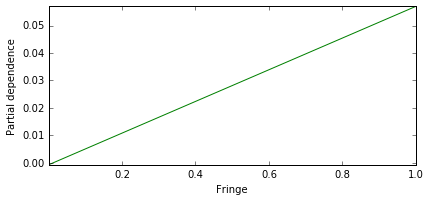

In [79]:
fig,axs = plot_partial_dependence(gbr,X_train_m2,[4],feature_names=,n_jobs=1,grid_resolution=50)

In [31]:
np.mean(((lcv.predict(normalizer.transform(X_test)) + gbr.predict(X_test_m))/2 - y_test)**2)

0.32071714739781892

In [ ]:
(((data.Cat=="Green").sum()*0.11545806607753986 +
 (data.Cat=="Fairway").sum()*0.31740937289 +
 (data.Cat=="Intermediate Rough").sum()*0.300202209856 +
 (data.Cat=="Primary Rough").sum()*0.361347962243 +
 (data.Cat=="Fringe").sum()*0.182508595153 + 
 (data.Cat=="Bunker").sum()*0.372257282426 +
 (data.Cat=="Other").sum()*0.493646743899)/len(data))**.5

In [ ]:
data = data[data.Cat=="Green"]

In [ ]:
X = data.values[:,2:].astype(float)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
pca = PCA()

In [ ]:
X_s = scaler.fit_transform(X)
X_t = pca.fit_transform(X_s)

In [ ]:
X_t.shape

In [ ]:
pca.explained_variance_ratio_

In [ ]:
np.dot(X_t,pca.components_)[0]

In [ ]:
pca.components_

In [ ]:
plt.scatter(X_t[:,0],X_t[:,1],alpha=.03)

In [ ]:
y = data.values[:,0]

In [ ]:
X = data.values[:,np.array([2,4])]
data = None
gc.collect()